In [1]:
# przetwarzanie danych
import numpy as np
import pandas as pd

# przekształcanie – normalizacja danych
from sklearn.preprocessing import MinMaxScaler

# wizualizacja
import matplotlib.pyplot as plt

# sieci neuronowe
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU

# ewaluacja modelu
from sklearn.metrics import mean_squared_error

In [2]:
dataset = pd.read_csv('../Files/airline-passengers.csv')
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.set_index(['Month'], inplace=True)
dataset

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


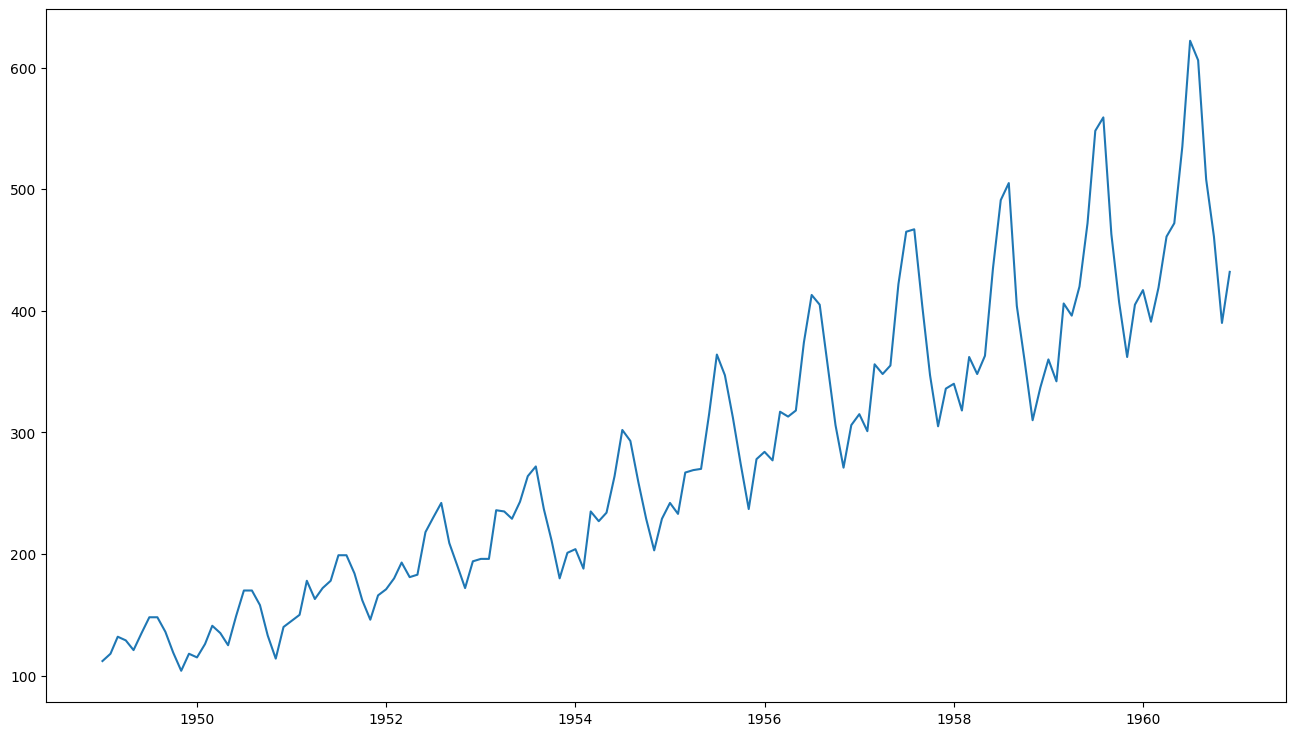

In [3]:
plt.figure(figsize=(16,9))
plt.plot(dataset['Passengers'])
plt.show()

##### Przygotowanie danych i podziału

In [4]:
train_size = int(len(dataset) * 0.70)
scaler = MinMaxScaler(feature_range=(0, 1))
look_back = 3

def create_dataset(df, train_size, lback=look_back, scaler_function=scaler):
    test_size = len(df) - train_size
    train, test = df[0:train_size,:].copy(), df[train_size:len(df),:].copy()
    train = scaler_function.fit_transform(train)
    test = scaler_function.transform(test)
    X_train, X_test, y_train, y_test = [], [], [], []

    # Tworzenie zbioru treninowego
    for i in range(len(train)-lback-1):
        a = train[i:(i+lback), 0]
        X_train.append(a)
        y_train.append(train[i + lback, 0])

    # Tworzenie zbioru testowego
    for i in range(len(test)-lback-1):
        a = test[i:(i+lback), 0]
        X_test.append(a)
        y_test.append(test[i + lback, 0])

    X_train, X_test = np.array(X_train), np.array(X_test)
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))  # np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    y_train, y_test = np.array(y_train), np.array(y_test)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = create_dataset(df=np.array(dataset), train_size=train_size, lback=look_back)

In [5]:
X_train[:3]

array([[[0.02588997, 0.04530744, 0.09061489]],

       [[0.04530744, 0.09061489, 0.08090615]],

       [[0.09061489, 0.08090615, 0.05501618]]])

##### RNN

In [6]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(5, input_shape=(1, look_back)))
model_rnn.add(Dense(1))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
model_rnn.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1)

Epoch 1/200
96/96 [==============================] - 1s 871us/step - loss: 0.1075
Epoch 2/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0289
Epoch 3/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0213
Epoch 4/200
96/96 [==============================] - 0s 988us/step - loss: 0.0170
Epoch 5/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0141
Epoch 6/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 7/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 8/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 9/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 10/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0097
Epoch 11/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0094
Epoch 12/200
96/96 [==============================] - 0s 967us/step - loss: 0.0094
Epoch 13/200
96/96 [===========

96/96 [==============================] - 0s 920us/step - loss: 0.0058
Epoch 102/200
96/96 [==============================] - 0s 967us/step - loss: 0.0054
Epoch 103/200
96/96 [==============================] - 0s 903us/step - loss: 0.0056
Epoch 104/200
96/96 [==============================] - 0s 891us/step - loss: 0.0057
Epoch 105/200
96/96 [==============================] - 0s 892us/step - loss: 0.0057
Epoch 106/200
96/96 [==============================] - 0s 963us/step - loss: 0.0055
Epoch 107/200
96/96 [==============================] - 0s 952us/step - loss: 0.0061
Epoch 108/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0059
Epoch 109/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0059
Epoch 110/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 111/200
96/96 [==============================] - 0s 973us/step - loss: 0.0054
Epoch 112/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 113/200


96/96 [==============================] - 0s 981us/step - loss: 0.0053


In [7]:
def backtests(model, lback=look_back):

    # predykcja - train
    prediction_train = scaler.inverse_transform(model.predict(X_train))
    prediction_train = pd.Series(prediction_train.flatten(),
                                index=dataset.index[lback:len(prediction_train)+lback])

    # predykcja - test
    prediction_test = scaler.inverse_transform(model.predict(X_test))
    prediction_test = pd.Series(prediction_test.flatten(),
                                index=dataset.index[train_size + look_back:train_size + look_back + len(prediction_test)])

    # wizualizacja prognozy
    plt.figure(figsize=(16,9))
    plt.plot(dataset['Passengers'], color='blue', label='True values')
    plt.plot(prediction_train, color='green', label='Prediction - Train')
    plt.plot(prediction_test, color='red', label='Prediction - Test')
    plt.legend(loc='upper left')
    plt.show()

    # obliczenie RMSE
    rmse = mean_squared_error(dataset.loc[prediction_test.index, :], prediction_test) ** 0.5
    print(f'\nRMSE TEST: {rmse}')

##### LSTM

Epoch 1/200
96/96 [==============================] - 1s 1ms/step - loss: 0.0888
Epoch 2/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0306
Epoch 3/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0194
Epoch 4/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0167
Epoch 5/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0146
Epoch 6/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0131
Epoch 7/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0119
Epoch 8/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 9/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0104
Epoch 10/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 11/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 12/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0097
Epoch 13/200
96/96 [=================

96/96 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 103/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 104/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 105/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 106/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 107/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 108/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 109/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 110/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 111/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 112/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 113/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 114/200
96/96 [=========

2/2 [==============================] - 0s 2ms/step


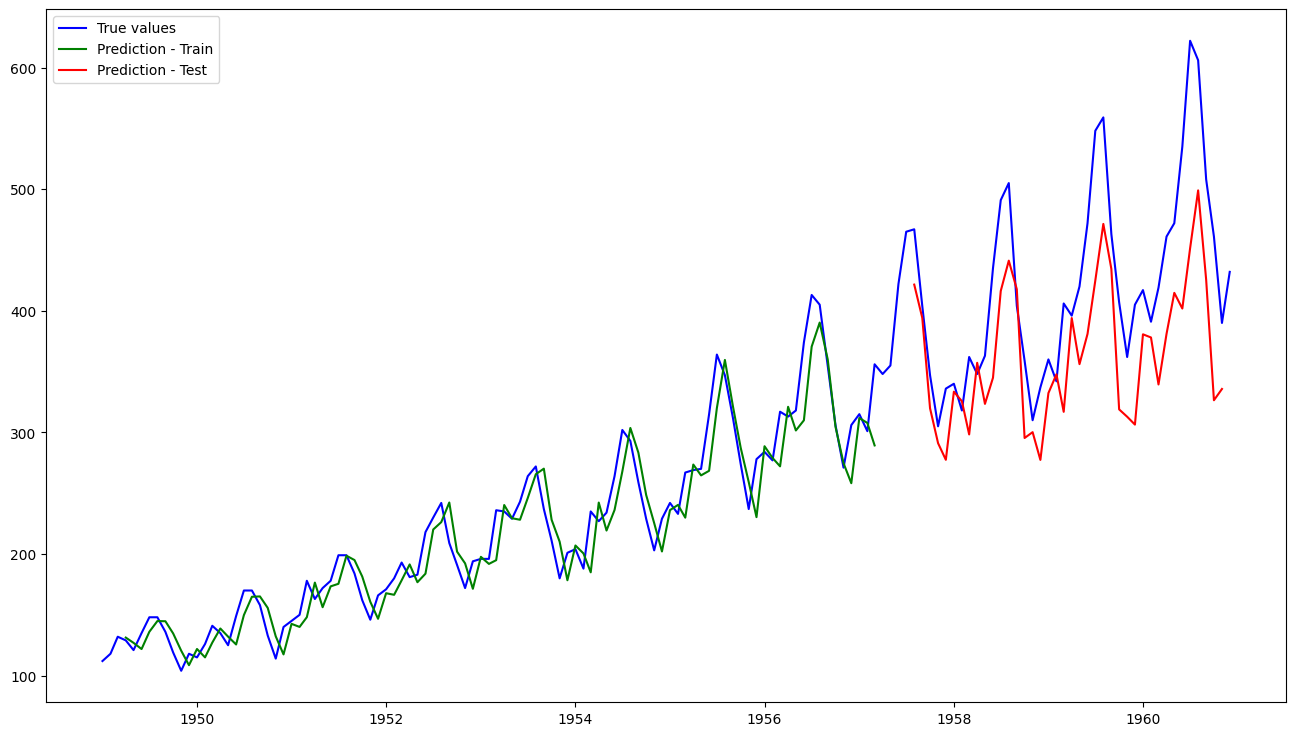


RMSE TEST: 71.81351207725623


In [8]:
model_lstm = Sequential()
model_lstm.add(LSTM(5, input_shape=(1, look_back)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1)
backtests(model_lstm)

##### GRU

Epoch 1/200
96/96 [==============================] - 1s 1ms/step - loss: 0.0211 
Epoch 2/200
96/96 [==============================] - 0s 932us/step - loss: 0.0145
Epoch 3/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0133
Epoch 4/200
96/96 [==============================] - 0s 989us/step - loss: 0.0128
Epoch 5/200
96/96 [==============================] - 0s 993us/step - loss: 0.0123
Epoch 6/200
96/96 [==============================] - 0s 949us/step - loss: 0.0119
Epoch 7/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0119
Epoch 8/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0114
Epoch 9/200
96/96 [==============================] - 0s 980us/step - loss: 0.0113
Epoch 10/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 11/200
96/96 [==============================] - 0s 966us/step - loss: 0.0107
Epoch 12/200
96/96 [==============================] - 0s 914us/step - loss: 0.0105
Epoch 13/200
96/96 [==

96/96 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 101/200
96/96 [==============================] - 0s 980us/step - loss: 0.0054
Epoch 102/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 103/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 104/200
96/96 [==============================] - 0s 985us/step - loss: 0.0055
Epoch 105/200
96/96 [==============================] - 0s 963us/step - loss: 0.0055
Epoch 106/200
96/96 [==============================] - 0s 971us/step - loss: 0.0055
Epoch 107/200
96/96 [==============================] - 0s 956us/step - loss: 0.0054
Epoch 108/200
96/96 [==============================] - 0s 990us/step - loss: 0.0054
Epoch 109/200
96/96 [==============================] - 0s 941us/step - loss: 0.0054
Epoch 110/200
96/96 [==============================] - 0s 1000us/step - loss: 0.0053
Epoch 111/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 112/200

96/96 [==============================] - 0s 954us/step - loss: 0.0051
Epoch 199/200
96/96 [==============================] - 0s 963us/step - loss: 0.0052
Epoch 200/200
2/2 [==============================] - 0s 4ms/step


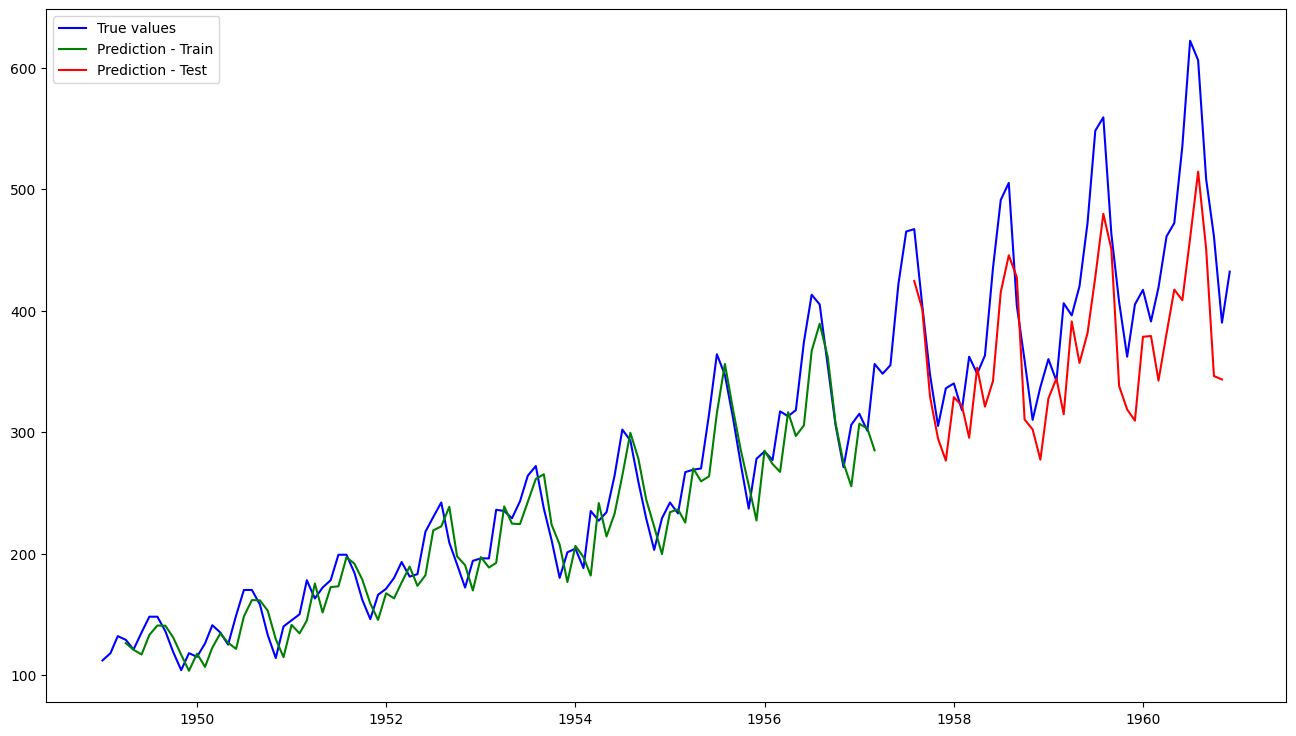


RMSE TEST: 67.37218065277757


In [9]:
model_gru = Sequential()
model_gru.add(GRU(5, input_shape=(1, look_back)))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')
model_gru.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1)
backtests(model_gru)

##### Podział zbioru treningowego na zbiór treningowy i walidacyjny

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Tworzenie siatki hiperparametrów i przeprowadzanie testów
look_back_range = range(1, 13)
units_range = range(1, 13)
results = []

for look_back in look_back_range:
    for units in units_range:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  # Resetowanie danych

        X_train, X_test, y_train, y_test = create_dataset(df=np.array(dataset), train_size=train_size, lback=look_back)  # Użycie 'lback' zamiast 'look_back'

        model_lstm = Sequential()
        model_lstm.add(LSTM(units, input_shape=(1, look_back)))
        model_lstm.add(Dense(1))
        model_lstm.compile(loss='mean_squared_error', optimizer='adam')
        model_lstm.fit(X_train, y_train, epochs=200, batch_size=1, verbose=0)

        prediction_test = scaler.inverse_transform(model_lstm.predict(X_test))
        prediction_test = pd.Series(prediction_test.flatten(),
                                    index=dataset.index[train_size + look_back:train_size + look_back + len(prediction_test)])

        rmse = mean_squared_error(dataset.loc[prediction_test.index, 'Passengers'], prediction_test) ** 0.5
        results.append({'look_back': look_back, 'units': units, 'rmse': rmse})

# Wyświetlenie wyników dla różnych hiperparametrów
for result in results:
    print(f"look_back: {result['look_back']}, units: {result['units']}, RMSE: {result['rmse']}")


1/1 [==============================] - 0s 363ms/step


1/1 [==============================] - 0s 298ms/step
look_back: 1, units: 1, RMSE: 67.5562507712893
look_back: 1, units: 2, RMSE: 58.306609084194996
look_back: 1, units: 3, RMSE: 57.09963331009569
look_back: 1, units: 4, RMSE: 62.12612042695218
look_back: 1, units: 5, RMSE: 54.14179844274196
look_back: 1, units: 6, RMSE: 58.50224286671193
look_back: 1, units: 7, RMSE: 54.98340344215672
look_back: 1, units: 8, RMSE: 55.995883298680276
look_back: 1, units: 9, RMSE: 54.77168102410177
look_back: 1, units: 10, RMSE: 53.904271853792004
look_back: 1, units: 11, RMSE: 51.631241730304694
look_back: 1, units: 12, RMSE: 55.46564031793157
look_back: 2, units: 1, RMSE: 76.33900494214619
look_back: 2, units: 2, RMSE: 69.15136386297614
look_back: 2, units: 3, RMSE: 63.63782259938293
look_back: 2, units: 4, RMSE: 53.14000267503047
look_back: 2, units: 5, RMSE: 64.53164601732372
look_back: 2, units: 6, RMSE: 63.617380560333
look_back: 2, units: 7, RMSE: 52.72535136513508
look_back: 2, units: 8, RMSE: 6

1/1 [==============================] - 0s 292ms/step


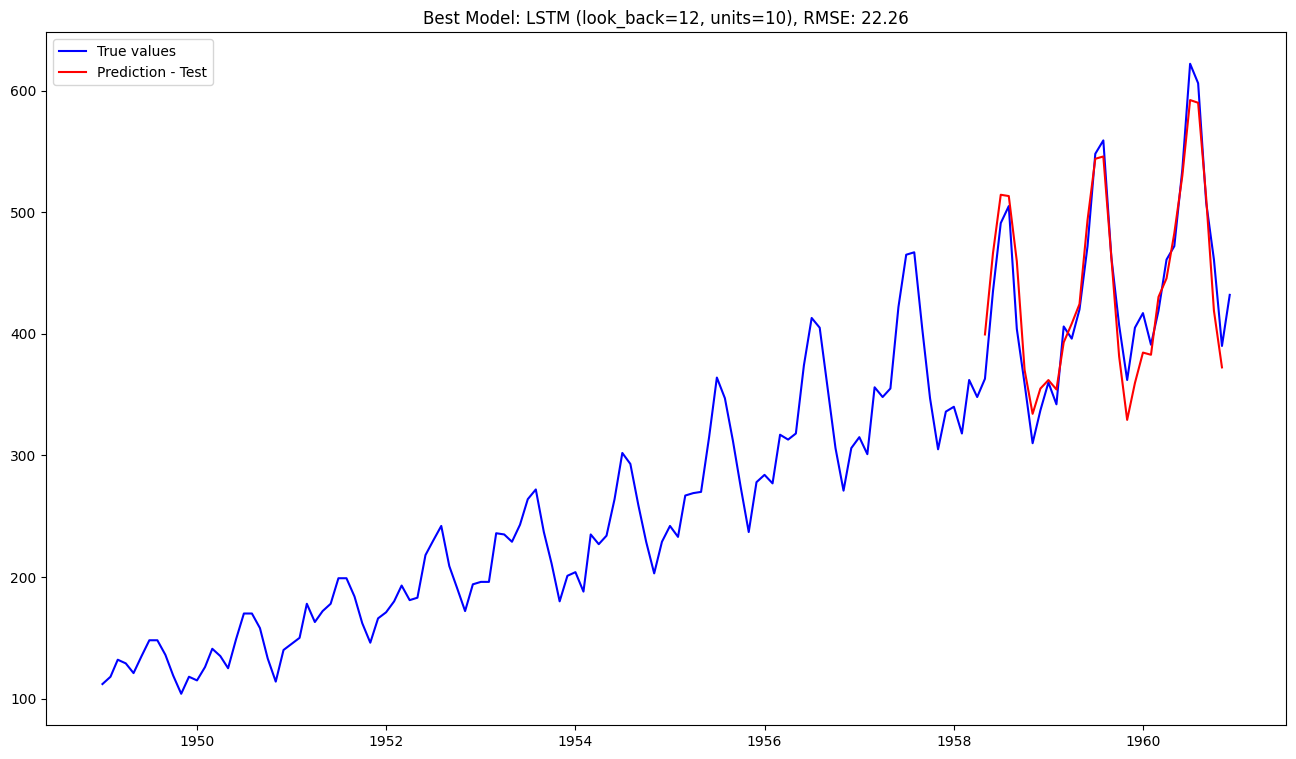

In [12]:
# Model z najniższym RMSE
best_rmse_idx = np.argmin([result['rmse'] for result in results])

best_look_back = results[best_rmse_idx]['look_back']
best_units = results[best_rmse_idx]['units']

# Ponowne tworzenie danych
X_train, X_test, y_train, y_test = create_dataset(df=np.array(dataset), train_size=train_size, lback=best_look_back)

# Tworzenie i trenowanie modelu
best_model_lstm = Sequential()
best_model_lstm.add(LSTM(best_units, input_shape=(1, best_look_back)))
best_model_lstm.add(Dense(1))
best_model_lstm.compile(loss='mean_squared_error', optimizer='adam')
best_model_lstm.fit(X_train, y_train, epochs=200, batch_size=1, verbose=0)

prediction_test = scaler.inverse_transform(best_model_lstm.predict(X_test))
prediction_test = pd.Series(prediction_test.flatten(),
                            index=dataset.index[train_size + best_look_back:train_size + best_look_back + len(prediction_test)])

# Wykres
plt.figure(figsize=(16, 9))
plt.plot(dataset['Passengers'], color='blue', label='True values')
plt.plot(prediction_test, color='red', label='Prediction - Test')
plt.legend(loc='upper left')
plt.title(f"Best Model: LSTM (look_back={best_look_back}, units={best_units}), RMSE: {results[best_rmse_idx]['rmse']:.2f}")
plt.show()